## Analysis of Fast automated drift correction for functional SPM imaging
Code by: Marti Checa

Publication: Mcheca et al "Fast automated drift correction for functional SPM imaging"

## Imports

In [1]:
from __future__ import division, print_function, absolute_import
from scipy.io import loadmat
import glob
import os
import skimage
import time

import pywt # conda install pywavelets
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import cv2
from scipy.io import savemat
from scipy import interpolate
from skimage.restoration import inpaint

from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.transform import warp
#from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from celluloid import Camera

from PIL import Image
from defisheye import Defisheye

import win32com.client  

print("Cloning package for GP analysis of hyperspectral data...", end=" ")
os.chdir(r'C:\Users\3un\Desktop\Jupyter Notebooks')
import torch
from gprocess import gprutils, skgpr, gpr
torch.set_default_tensor_type(torch.DoubleTensor)

Cloning package for GP analysis of hyperspectral data... 

## Compresed sensing function

In [2]:
def SSTEM(yspar,mask,itern,levels,lambd):  
############################################
#INPUT: 
#yspar: sparse image as an array, to reduce iteration numer, better rescaling the value to [0,1]
#mask: binary array, 1 indicationg sampled pixel locations
#itern: iteration number, usually 20 is enough
#levels: wavelet level, common choice 2,3,4, larger value for larger feature size, if too blur, change to smaller one
#lambd: threshold value, usually 0.8 is fine

#Output: Inpaited image
#############################################   
    fSpars = yspar
    W_thr = [0]*levels;

    ProjC = lambda f, Omega: (1-Omega)*f + Omega*yspar
    
    for i in range(itern):
        fSpars = ProjC(fSpars, mask)
        W_pro = pywt.swt2(fSpars, 'db2',levels)
        for j in range(levels):
            sA = W_pro[j][0]
            sH = W_pro[j][1][0]
            sV = W_pro[j][1][1]
            sD = W_pro[j][1][2]
            W_thr[j] = (pywt.threshold(sA,0,'soft')),(pywt.threshold(sH,lambd,'soft'),
                        pywt.threshold(sV,lambd,'soft'),pywt.threshold(sD,lambd,'soft'))    
        fSpars = pywt.iswt2(W_thr,'db2')
    return fSpars

## Gaussian Process function

In [3]:
def GP_Structured(imgdata,iter__):
  
  R = imgdata
  R[R == R[1, 1]] = np.nan # Take value at [1, 1] as missing data value


  # Construct a grid for the FOV:
  e1, e2 = R.shape
  xx, yy = np.mgrid[:e1:1., :e2:1.]
  X_true = np.array([xx, yy])
  # Get sparse grid corresponding to measurements
  X, R = gprutils.corrupt_data_xy(X_true, R)

  lengthscale = [[1., 1.], [4., 4.]]
  # type of kernel ('RBF' or 'Matern52')
  kernel = 'RBF'
  
  for ii in range(iter__):
    skreconstructor = skgpr.skreconstructor(X, R, X_true, kernel, 
                                            lengthscale=lengthscale,
                                            input_dim=2, grid_points_ratio=1.,  
                                            learning_rate=0.5, iterations=ii, 
                                            calculate_sd=True, num_batches=1,
                                            use_gpu=False, verbose=False)
    (mean, sd), hyperparams = skreconstructor.run()
    # lengthscale constraints
    # lengthscale = [[1., 1.], [4., 4.]]
    # # type of kernel ('RBF' or 'Matern52')
    # kernel = 'RBF'
    # # Run GP
    # reconstructor = gpr.reconstructor(X, R, X_true, kernel,
    #                                   lengthscale=lengthscale,
    #                                   input_dim=2, indpoints=200, 
    #                                   learning_rate=0.1, iterations=ii, 
    #                                   use_gpu=True, verbose=True)
    # mean, sd, hyperparams = reconstructor.run()

    gp_data= mean.reshape(128,128)
    gp_data_norm = (gp_data -gp_data.min())/ np.ptp(gp_data)

  return gp_data

## Function shift correction

In [4]:
def shift_correction(topo_recon_norm1,topo_recon_norm2,mask_recon,res_factor):
#we calculate the phase crosscorrelation
    image0 = (topo_recon_norm1)
    image1 = (topo_recon_norm2)

#We resize the image to account for subpixel resultion in the drift calculation
    image0  = cv2.resize(image0 , dsize=(image0.shape[0]*res_factor, image0.shape[1]*res_factor), interpolation=cv2.INTER_CUBIC)
    image1  = cv2.resize(image1 , dsize=(image1.shape[0]*res_factor, image1.shape[1]*res_factor), interpolation=cv2.INTER_CUBIC)
    mask_recon_resize = cv2.resize(mask_recon , dsize=(mask_recon.shape[0]*res_factor, mask_recon.shape[1]*res_factor), interpolation=cv2.INTER_CUBIC)

# --- Compute the phase crosscorrelation
    shift = phase_cross_correlation(image0, image1,reference_mask=mask_recon_resize, moving_mask=mask_recon_resize)

    print('The shift vector is:', shift)

# --- Display
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(6, 4))

# --- Sequence image sample

    im1=ax0.imshow(image0, cmap='viridis')
    ax0.set_title("Image 0")
    ax0.set_axis_off()

    im2=ax1.imshow(image1, cmap='viridis')
    ax1.set_title("Image 1")
    ax1.set_axis_off()

    ax0.quiver(image0.shape[0]/2, image0.shape[0]/2, -shift[1]*10, -shift[0]*10, color='r', units='width',
           angles='xy', scale_units='xy', lw=3, scale=0.5) #this plots the mean optical flow

    ax0.set_axis_off()

    im3=ax2.imshow(abs(image0-image1), cmap='viridis')
    ax2.set_title("Difference")
    ax2.set_axis_off()
    fig.tight_layout()
    plt.show()
    
    return shift

## Import Single image file, adjust CS parameters and perform compresed sensing

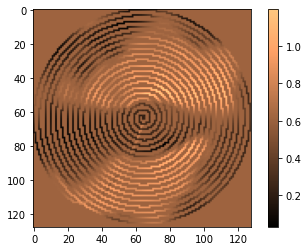

Mean = 0.5713845395700164
Std = 0.30188177937109206


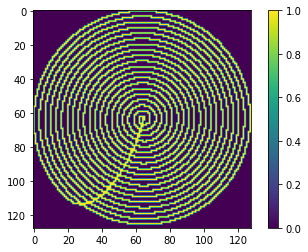

Number of pixels scanned --> 5201


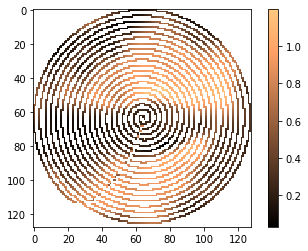

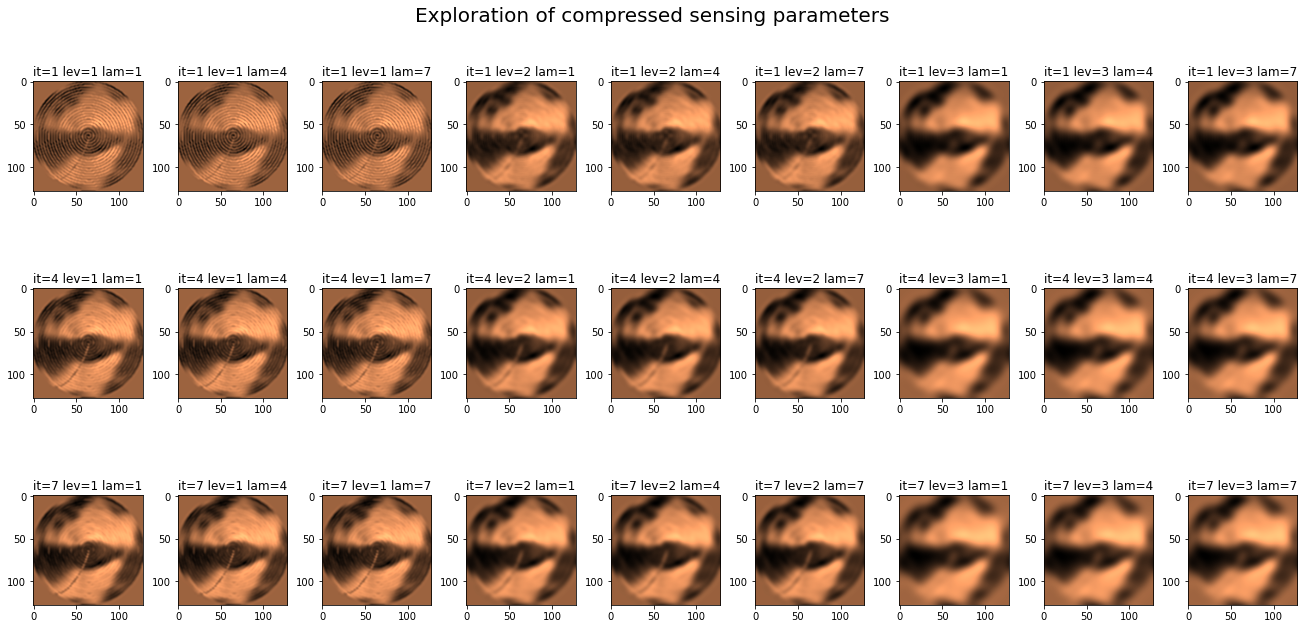

In [5]:
%matplotlib inline
#Set parameters to save data
path_save= r'F:\ORNL\Experimental data\Cypher North\2023\Jan\13th\spiral scan\region 4\20cycles_1sec_trackingv2\\'
filename=path_save+'CIPS_IPS_Flake_5_ai0.txt'
imagesize=128

#Unwanted pixels array
array20x=[69,69,70,64,65,66,72,73,74,76,77,77,78,80,80,81,82,84,84,85,86,87,88,88,89,91,91,92,93,94,95,96,96,98,99,99,101,101,102,103,103,104,105,105,106,107,108,108,109,110,110,111,111,113,113,113,113,113,114,114,113,114]
array20y=[63,64,63,64,64,64,62,62,62,61,61,60,60,60,59,59,59,58,57,57,57,56,56,55,55,54,53,53,53,51,51,51,50,49,49,48,46,47,46,46,45,44,44,43,43,41,41,40,40,38,37,36,37,30,31,32,33,34,27,28,26,26]

#plot the data
plt.figure()
topo=np.loadtxt(filename, delimiter=',')
plt.imshow(topo,cmap='copper')
plt.colorbar()
plt.show()

cont=0
#we find the mask
mask=np.zeros((imagesize,imagesize))
for ii in range(topo.shape[0]):
    for jj in range(topo.shape[1]):
        if topo[ii,jj] != topo[0,0]:
            mask[ii,jj] = 1
            cont=cont+1
            
values=np.zeros((cont))
cont2=0
for ii in range(topo.shape[0]):
    for jj in range(topo.shape[1]):
        if topo[ii,jj] != topo[0,0]:
            values[cont2]=topo[ii,jj]
            cont2=cont2+1

#print Mean and std values
print('Mean = ' + str(np.mean(values)))
print('Std = ' + str(np.std(values)))
            
#plot the mask data
plt.figure()
plt.imshow(mask)
plt.colorbar()
plt.show()

print('Number of pixels scanned --> ' +str(np.count_nonzero(mask == 1)))

#plot the Raw data
plt.figure()
topo_plot=np.loadtxt(filename, delimiter=',')
topo_plot[mask==0]=np.nan
for i in range(len(array20x)):
    topo_plot[array20x[i],array20y[i]]=np.nan
    
plt.imshow(topo_plot,cmap='copper',interpolation='none')
plt.colorbar()
plt.show()

topo[mask==0]=topo[0,0]
for i in range(len(array20x)):
    topo[array20x[i],array20y[i]]=topo[0,0]
            
#find the correct CSensing parameters
n_steps=3
ite_ini=1
lev_ini=1
lam_ini=1
ite_step=3
lev_step=1
lam_step=3

fig, axs = plt.subplots(n_steps, (n_steps)**2,figsize=(n_steps*6,n_steps*3),constrained_layout=True)

for i in range(n_steps):
    itern= ite_ini+i*ite_step
    for j in range(n_steps):
        levels= lev_ini+j*lev_step
        for k in range(n_steps):
            lambd= lam_ini+k*lam_step
            
            topo_recon = SSTEM(topo,mask,itern,levels,lambd)
            param_print ='it=' + str(itern) +' lev='+ str(levels) + ' lam='+ str(lambd)
            axs[i,k+(j*n_steps)].imshow(topo_recon,cmap='copper')
            axs[i,k+(j*n_steps)].set_title(param_print)
            
plt.suptitle('Exploration of compressed sensing parameters',fontsize=20)
plt.show()

## Choose optimal compresed sensing parameters and compare with GP reconstruction

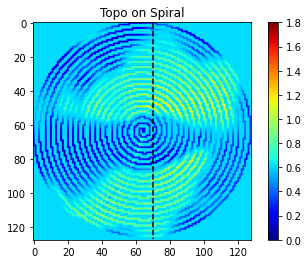

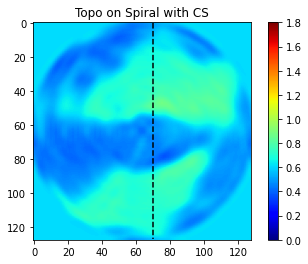

Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done


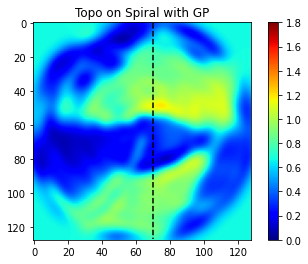

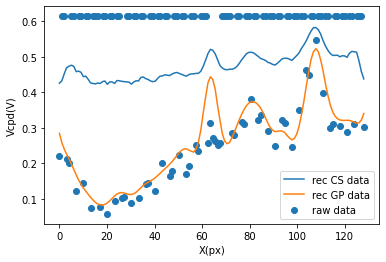

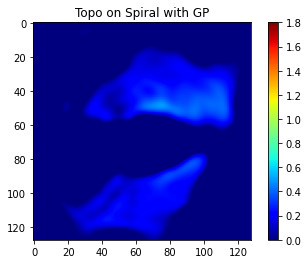

In [6]:
itern=1
levels=2
lambd=4

line=70

topo=np.loadtxt(filename, delimiter=',')
plt.imshow(topo,vmin=0,vmax=1.8,cmap='jet')
plt.plot(np.full((128,),line),np.linspace(0,imagesize-1,num=128),'--k')
plt.colorbar()
plt.title('Topo on Spiral')
plt.show()

topo_rec = SSTEM(topo,mask,itern,levels,lambd)

plt.imshow(topo_rec,vmin=0,vmax=1.8,cmap='jet')
plt.plot(np.full((128,),line),np.linspace(0,imagesize-1,num=128),'--k')
plt.colorbar()
plt.title('Topo on Spiral with CS')
plt.show()

#calculating GP reconstruction
topo_recGP = GP_Structured(topo,8);
topo=np.loadtxt(filename, delimiter=',')

plt.imshow(topo_recGP,vmin=0,vmax=1.8,cmap='jet')
plt.plot(np.full((128,),line),np.linspace(0,imagesize-1,num=128),'--k')
plt.colorbar()
plt.title('Topo on Spiral with GP')
plt.show()

plt.scatter(np.linspace(0,128,128),topo[line,:],label='raw data')
plt.plot(np.linspace(0,128,128),topo_rec[line,:],label='rec CS data')
plt.plot(np.linspace(0,128,128),topo_recGP[line,:],label='rec GP data')
plt.legend()
plt.xlabel('X(px)')
plt.ylabel('Vcpd(V)')
plt.show()

topo_recGP_toplot=topo_recGP-np.mean(topo_recGP[90,20:100])

plt.imshow(topo_recGP_toplot,vmin=0,vmax=1.8,cmap='jet')
#plt.plot(np.full((128,),line),np.linspace(0,imagesize-1,num=128),'--k')
plt.colorbar()
plt.title('Topo on Spiral with GP')
plt.show()

## Calculate CS for all frames in a temporal series data

Iteration=0


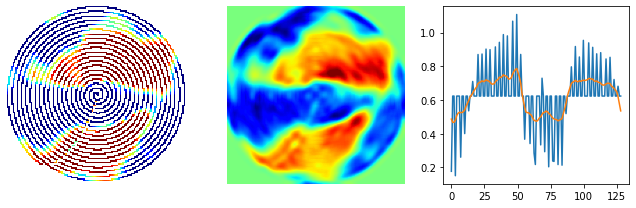

Iteration=1


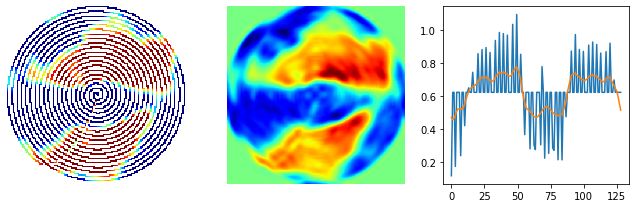

Iteration=2


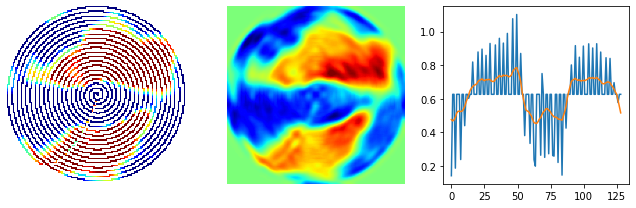

Iteration=3


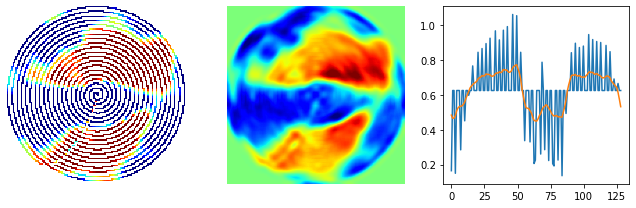

Iteration=4


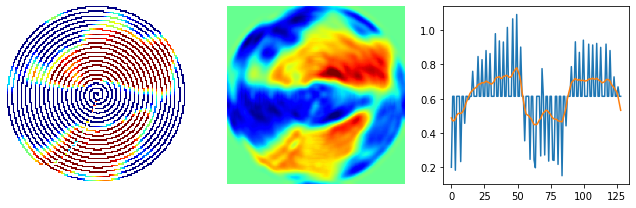

Iteration=5


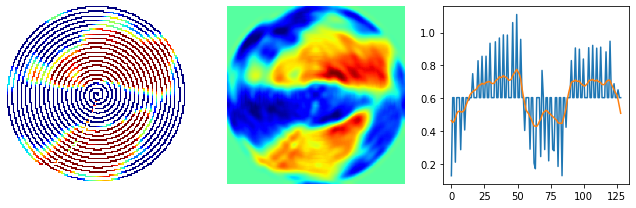

Iteration=6


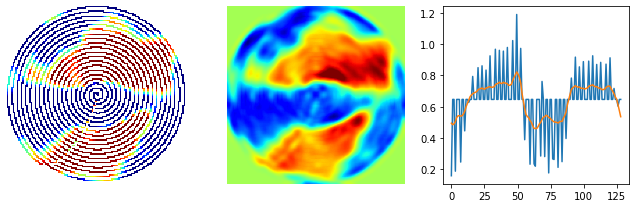

Iteration=7


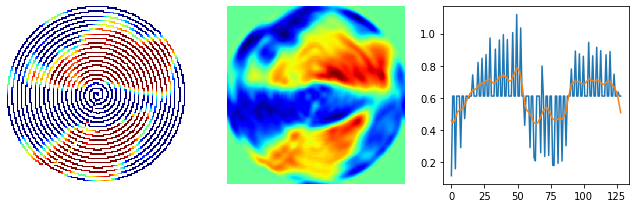

Iteration=8


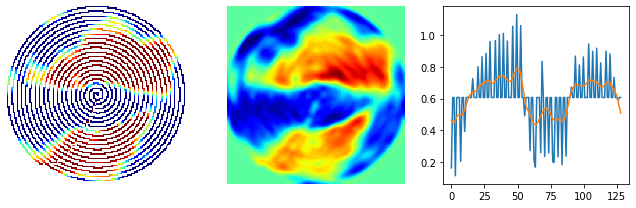

Iteration=9


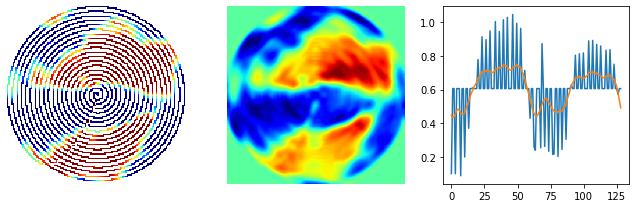

Iteration=10


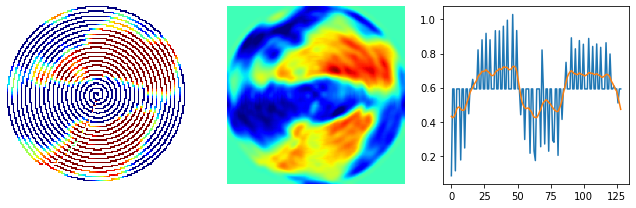

Iteration=11


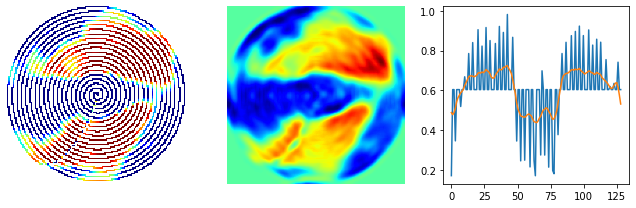

Iteration=12


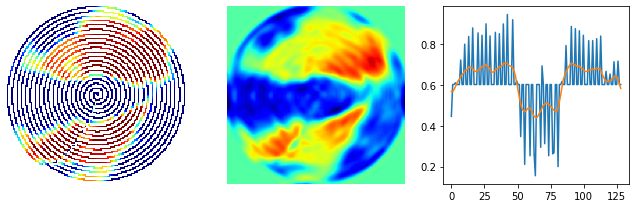

Iteration=13


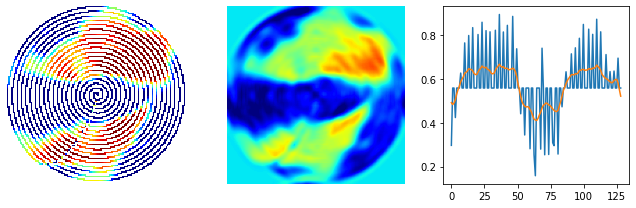

Iteration=14


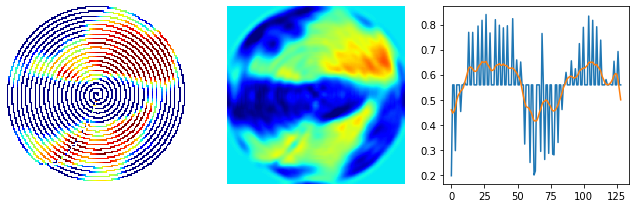

Iteration=15


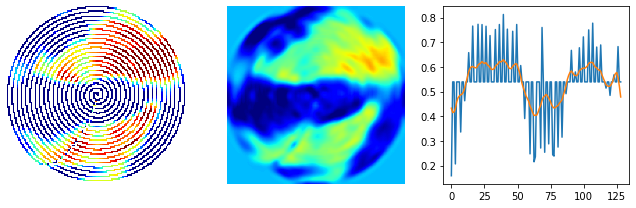

Iteration=16


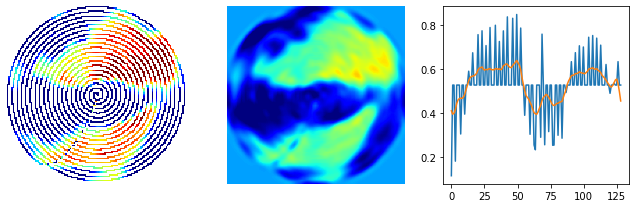

Iteration=17


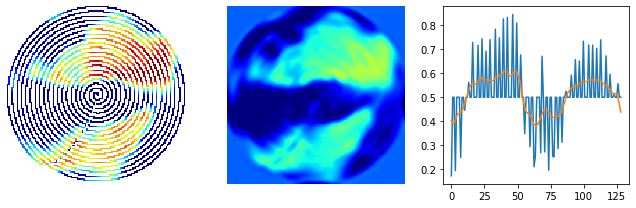

Iteration=18


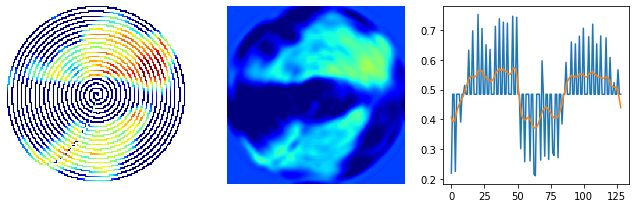

Iteration=19


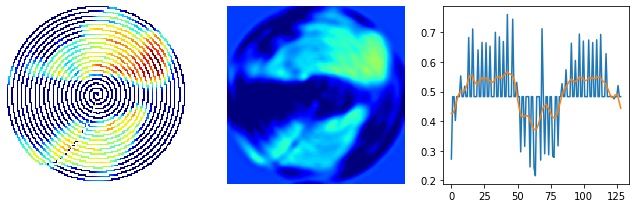

Iteration=20


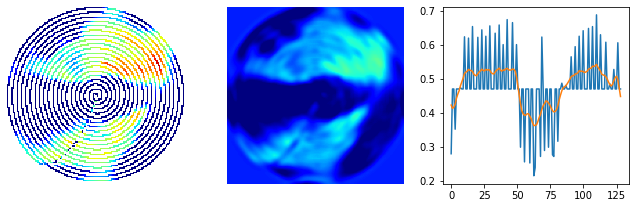

Iteration=21


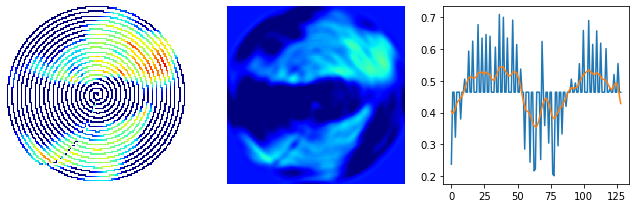

Iteration=22


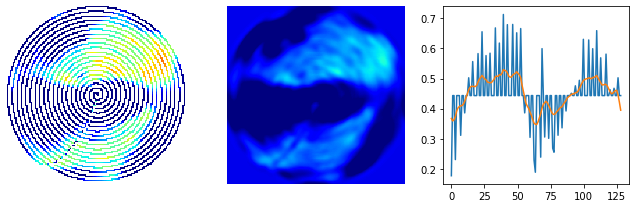

Iteration=23


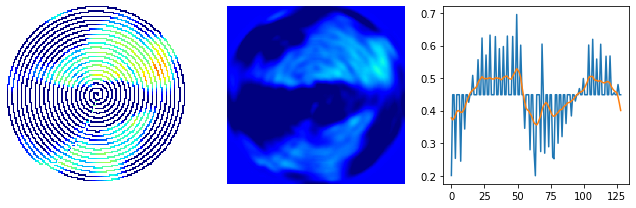

Iteration=24


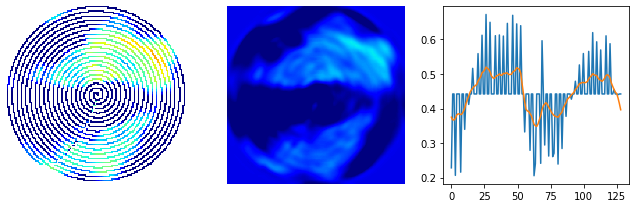

Iteration=25


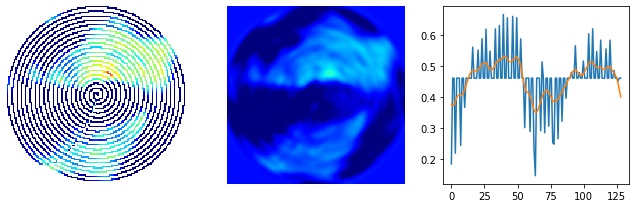

Iteration=26


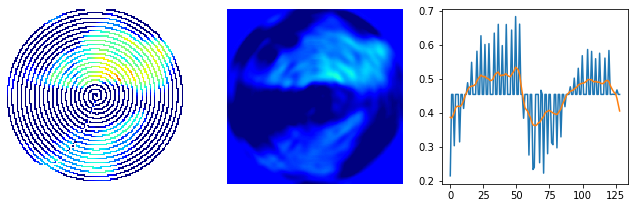

Iteration=27


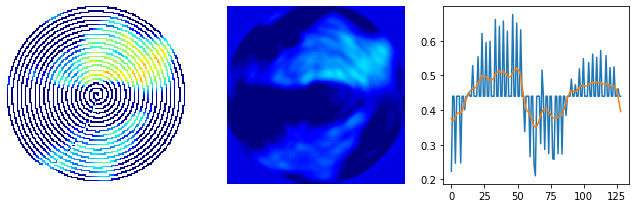

Iteration=28


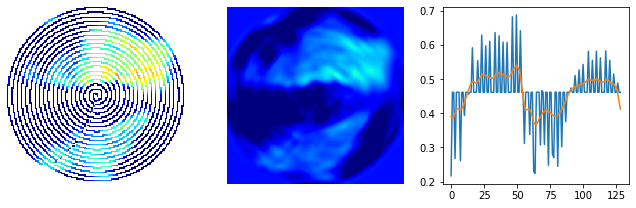

Iteration=29


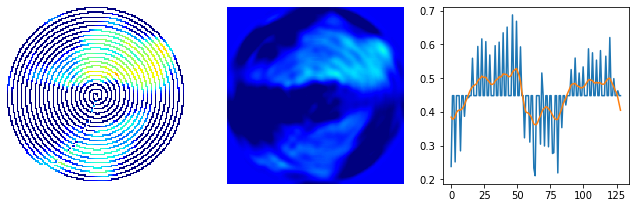

Iteration=30


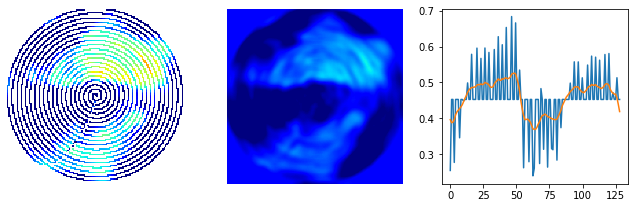

Iteration=31


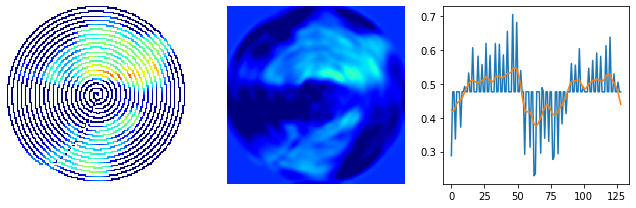

Iteration=32


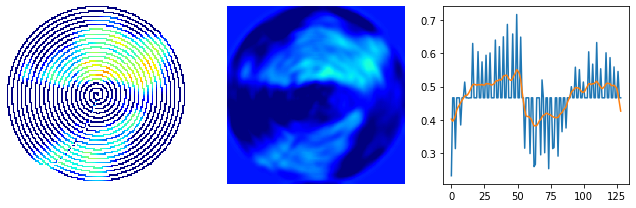

Iteration=33


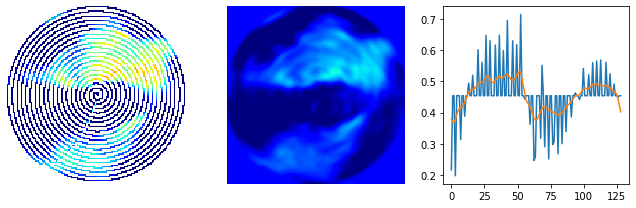

Iteration=34


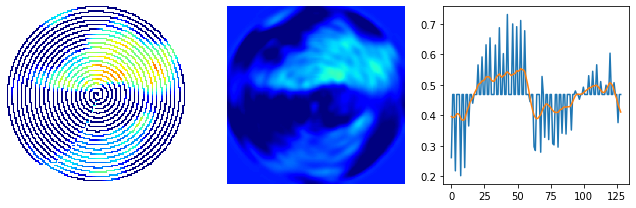

Iteration=35


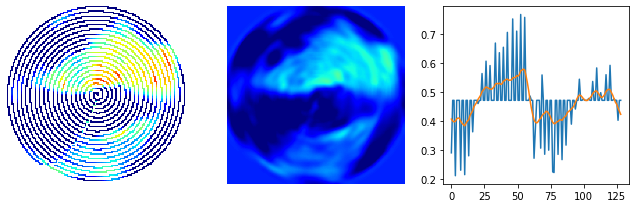

Iteration=36


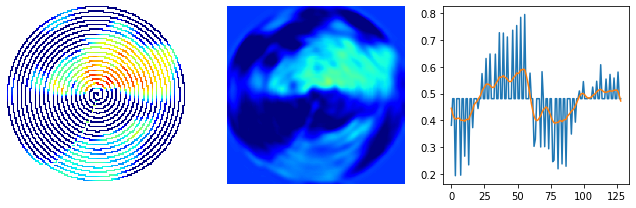

Iteration=37


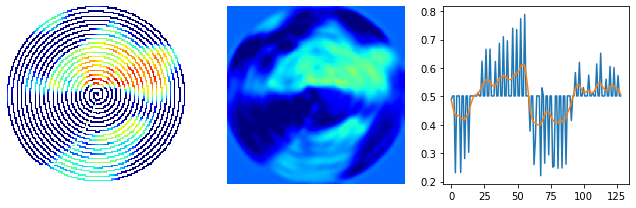

Iteration=38


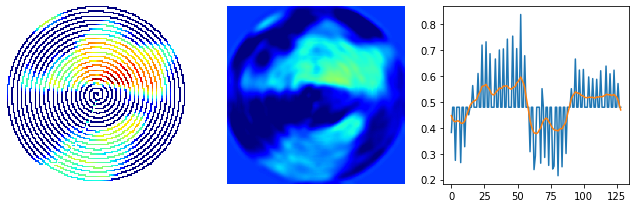

Iteration=39


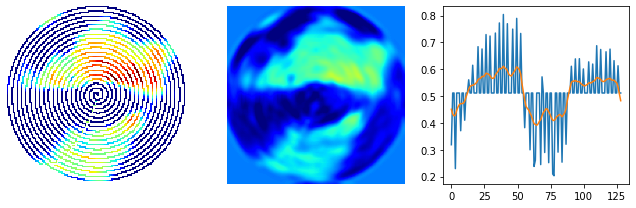

Iteration=40


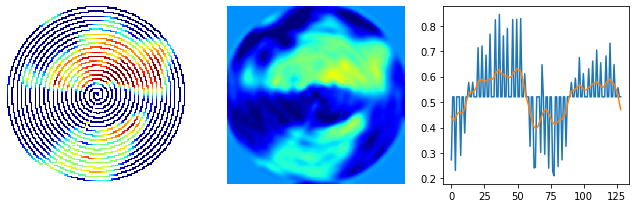

Iteration=41


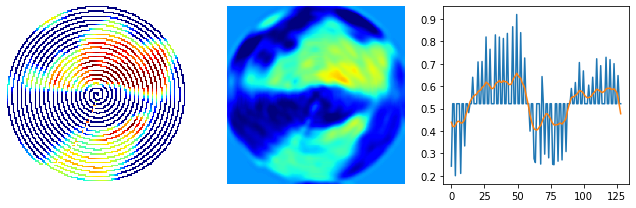

Iteration=42


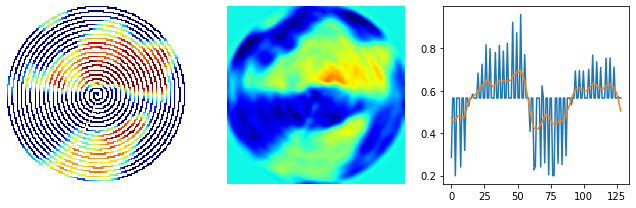

Iteration=43


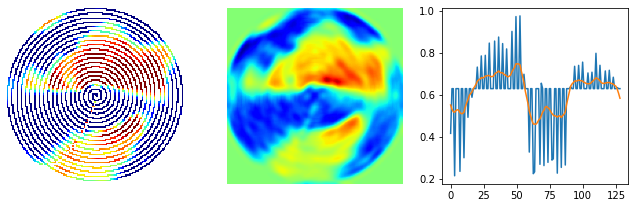

Iteration=44


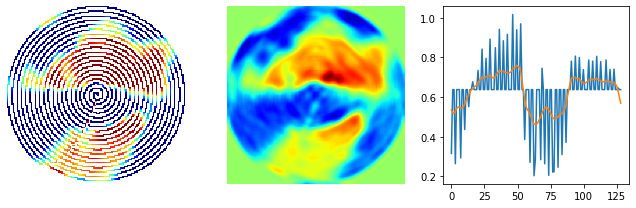

Iteration=45


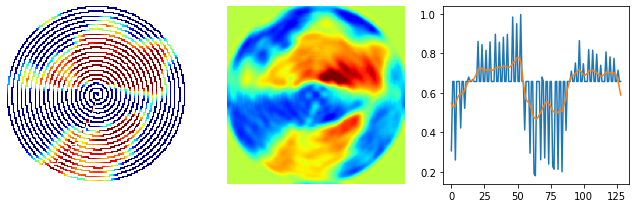

Iteration=46


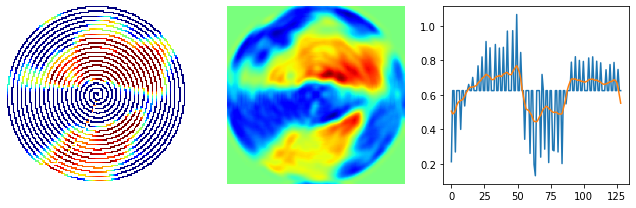

Iteration=47


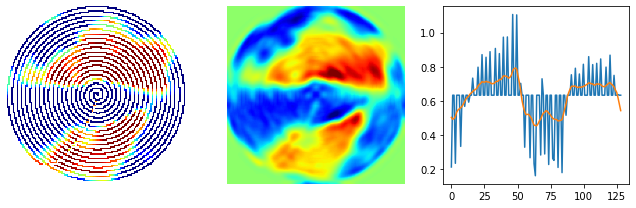

Iteration=48


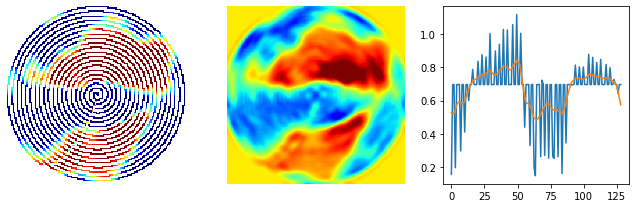

Iteration=49


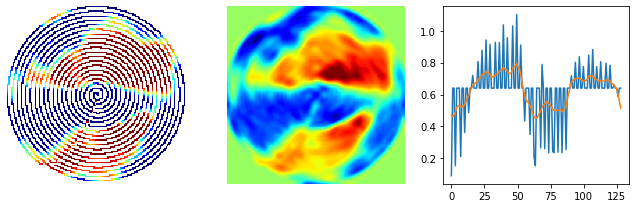

Iteration=50


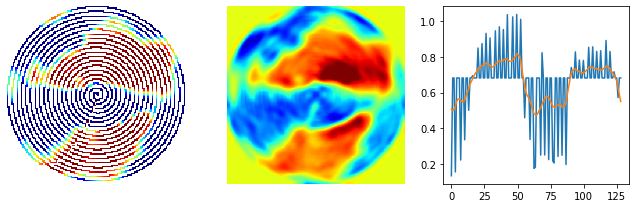

Iteration=51


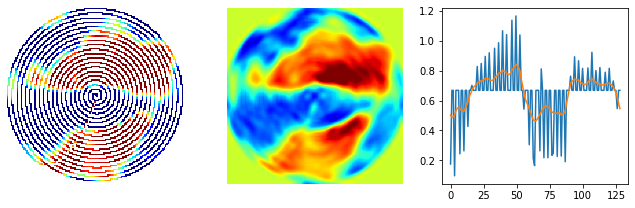

Iteration=52


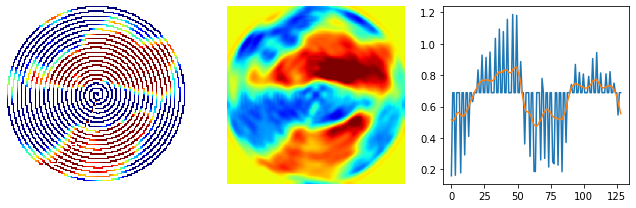

Iteration=53


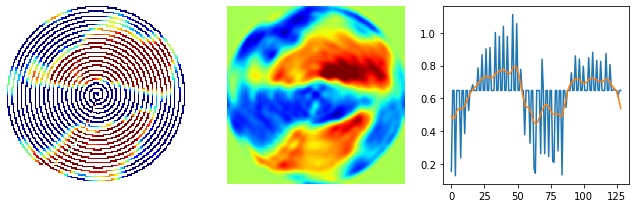

Iteration=54


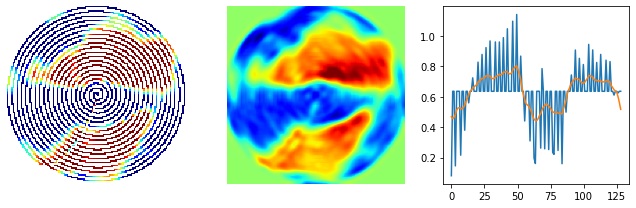

Iteration=55


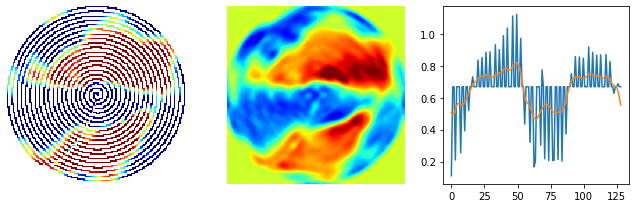

Iteration=56


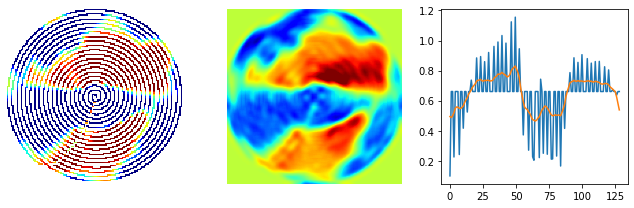

Iteration=57


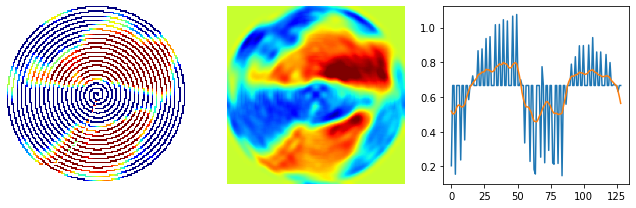

Iteration=58


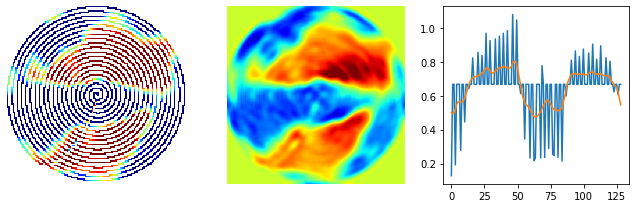

Iteration=59


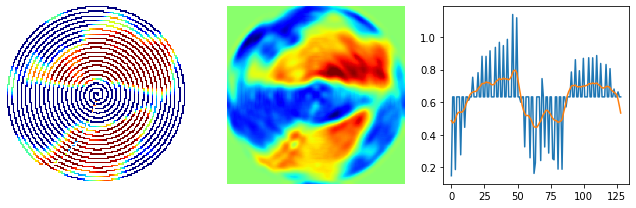

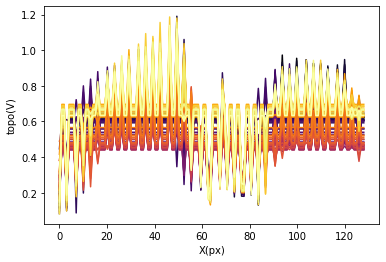

<function matplotlib.pyplot.show(close=None, block=None)>

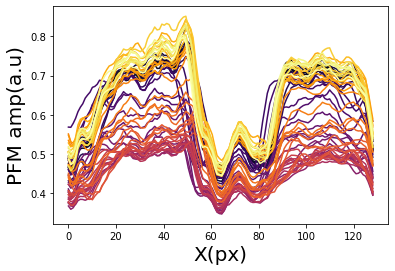

In [7]:
%matplotlib inline
itern=1
levels=2
lambd=4

n_frames=60
line=64
profiles=np.zeros((n_frames,imagesize))
profiles_rec=np.zeros((n_frames,imagesize))
profiles_rec_norm=np.zeros((n_frames,imagesize))

path_save= r'F:\ORNL\Experimental data\Cypher North\2023\Jan\13th\spiral scan\region 4\20cycles_1sec_trackingv2\\'


for i in range(n_frames):
    filename=path_save+'CIPS_IPS_Flake_'+str(i+1)+'_ai0.txt'
    print('Iteration='+str(i))
    
    topo=np.loadtxt(filename, delimiter=',')  
    topo[mask==0]=topo[0,0]
    for j in range(len(array20x)):
        topo[array20x[j],array20y[j]]=topo[0,0]
    topo_rec = SSTEM(topo,mask,itern,levels,lambd)
    profiles[i,:]=topo[:,line]
    profiles_rec[i,:]=topo_rec[:,line]
    
    #We calculate the normalized
    topo_norm= (topo - np.min(topo))/(np.max(topo) - np.min(topo)) 
    topo_rec_norm= (topo_rec - np.min(topo_rec))/(np.max(topo_rec) - np.min(topo_rec)) 
    profiles_rec_norm[i,:]=topo_rec_norm[:,line]
    
    topo_norm[mask==0]=np.nan
    for j in range(len(array20x)):
        topo_norm[array20x[j],array20y[j]]=np.nan
        
    topo[mask==0]=np.nan
    for j in range(len(array20x)):
        topo[array20x[j],array20y[j]]=np.nan
        
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    
    im1=ax[0].imshow(topo,vmin=0.4,vmax=0.85,cmap='jet',interpolation='none')
    ax[0].axis('off')
    ax[1].imshow(topo_rec,vmin=0.4,vmax=0.85,cmap='jet')
    ax[1].axis('off')
    ax[2].plot(np.linspace(0,128,128),profiles[i,:])
    ax[2].plot(np.linspace(0,128,128),profiles_rec[i,:])
    plt.tight_layout()
    
    plt.show()

colors = plt.cm.inferno(np.linspace(0,1,n_frames))
for i in range(n_frames):
    plt.plot(np.linspace(0,128,128),profiles[i,:],color=colors[i])

plt.xlabel('X(px)')
plt.ylabel('topo(V)')
plt.show()

for i in range(n_frames):
    if i!=15:
        plt.plot(np.linspace(0,128,128),profiles_rec[i,:],color=colors[i])
    
plt.xlabel('X(px)',fontsize=20)
plt.ylabel('PFM amp(a.u)',fontsize=20)
plt.show

## Visualization of the profile data across the phase transition

<ipython-input-9-8a9cd18b3523>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


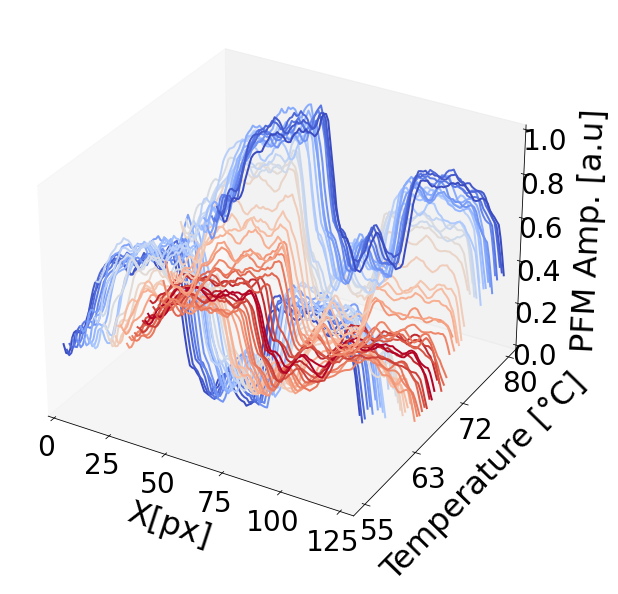

In [9]:
%matplotlib inline
#figure in 3D
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d',)
colors = plt.cm.coolwarm(np.linspace(0,1,int(n_frames/2)))

T_vec_up=np.linspace(55,80,30)
T_vec_down=np.linspace(80,55,30)
T_vec=np.append(T_vec_up, T_vec_down)

# Plot a sin curve using the x and y axes.
for i in range(n_frames):
    
    x = np.linspace(0,128,128)
    #y = np.linspace(T_vec[i],T_vec[i],128)
    y = np.linspace(i,i,128)
    zs = profiles_rec[i,:]
    zs=(zs - np.min(profiles_rec))/(np.max(profiles_rec) - np.min(profiles_rec)) 
    if i<int(n_frames/2):
        ax.plot(x, y, zs, zdir='z',linewidth=2,color=colors[i])
    else:
        ax.plot(x, y, zs, zdir='z',linewidth=2,color=colors[-1-(-int(n_frames/2)+i)])


fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '55'
labels[2] = '63'
labels[3] = '72'
labels[4] = '80'
labels[5] = '72'
labels[6] = '63'
labels[7] = '55'

ax.set_zlim([0,1])
ax.set_xlim([0,128])
ax.set_yticklabels(labels)            
ax.set_xlabel('X[px]',fontsize=32,labelpad=22)
ax.set_ylabel('Temperature [°C]',fontsize=32,labelpad=22)  
ax.set_zlabel('PFM Amp. [a.u]',fontsize=32,labelpad=22) 
ax.tick_params(axis='both', which='major', labelsize=28)

# make the panes transparent
#ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.show()

## Visualization of the piezoresponse data across the phase transition

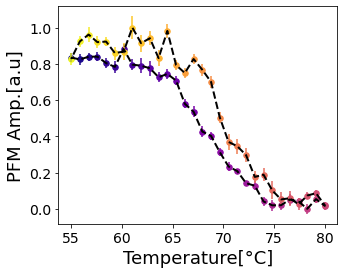

In [10]:
%matplotlib inline

deff=np.zeros([n_frames])
PFMerrs=np.zeros([n_frames])
T_vec_up=np.linspace(55,80,30)
T_vec_down=np.linspace(80,55,30)
T_vec=np.append(T_vec_up, T_vec_down)
colors = plt.cm.plasma(np.linspace(0,1,n_frames))

for i in range(n_frames):
    deff[i] = np.mean(np.concatenate((profiles_rec[i,20:40], profiles_rec[i,95:115])))
    PFMerrs[i]=2*np.std(np.concatenate((profiles_rec[i,20:40], profiles_rec[i,95:115])))
#nrmalize it: 
deff=(deff - np.min(deff))/(np.max(deff) - np.min(deff)) 
plt.figure(figsize=(5,4))
for i in range(n_frames):
    plt.scatter(T_vec[i],deff[i],color=colors[i],s=30) 
    plt.errorbar(T_vec[i],deff[i],yerr=PFMerrs[i],color=colors[i])  
    
plt.plot(T_vec,deff,'--k',linewidth=2)
plt.xlabel('Temperature[°C]',fontsize=18)
plt.ylabel('PFM Amp.[a.u]',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

## Generate the animation of the whole data (Raw data, reconstruction and profiles)

MovieWriter PillowWriter unavailable; using Pillow instead.


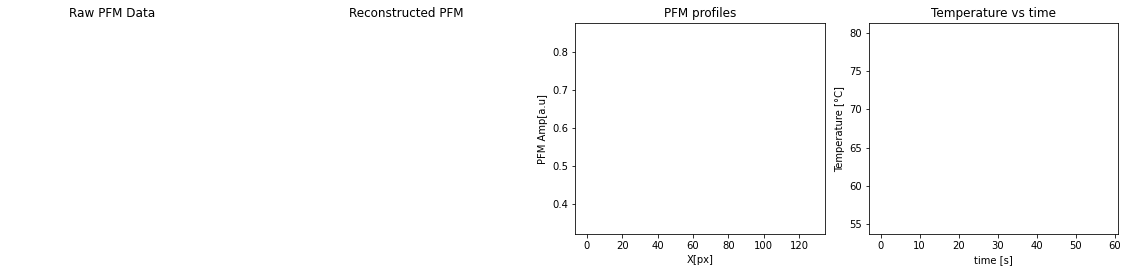

In [12]:
##Animation 
path_save= r'F:\ORNL\Experimental data\Cypher North\2023\Jan\13th\spiral scan\region 4\20cycles_1sec_trackingv2\\'
# We do the animation of the shift correction
os.chdir(path_save)

n_frames=60
start_frame=10

fig, ax = plt.subplots(1, 4, figsize=(16, 4.5))
ax[0].set_title('Raw PFM Data' )
ax[1].set_title('Reconstructed PFM')
ax[2].set_title('PFM profiles' )
ax[2].set_xlabel('X[px]')
ax[2].set_ylabel('PFM Amp[a.u]')
ax[0].axis('off')
ax[1].axis('off')
ax[3].set_title('Temperature vs time' )
ax[3].set_xlabel('time [s]')
ax[3].set_ylabel('Temperature [°C]')

T_vec_up=np.linspace(55,80,30)
T_vec_down=np.linspace(80,55,30)
T_vec=np.append(T_vec_up, T_vec_down)

colors = plt.cm.inferno(np.linspace(0,1,n_frames))

camera = Camera(fig)

for i in range(n_frames-1):
    
    if i!=7 and i!=17 and i!= 45 and i!=51:
    
        filename=path_save+'CIPS_IPS_Flake_'+str(i+start_frame+1)+'_ai0.txt'
    
        topo=np.loadtxt(filename, delimiter=',')  
        topo[mask==0]=topo[0,0]
        
        for j in range(len(array20x)):
            topo[array20x[j],array20y[j]]=topo[0,0]
        topo_rec = SSTEM(topo,mask,itern,levels,lambd)
        profiles[i,:]=topo[:,line]
        profiles_rec[i,:]=topo_rec[:,line]
    
        #We calculate the normalized
        topo_norm= (topo - np.min(topo))/(np.max(topo) - np.min(topo)) 
        topo_rec_norm= (topo_rec - np.min(topo_rec))/(np.max(topo_rec) - np.min(topo_rec)) 
        profiles_rec_norm[i,:]=topo_rec_norm[line,:]
    
        topo_norm[mask==0]=np.nan
        for j in range(len(array20x)):
            topo_norm[array20x[j],array20y[j]]=np.nan
            
        topo[mask==0]=np.nan
        for j in range(len(array20x)):
            topo[array20x[j],array20y[j]]=np.nan
    
        im1=ax[0].imshow(topo,vmin=0.45,vmax=0.9,cmap='jet',interpolation='none')
        ax[0].axis('off')
        im2=ax[1].imshow(topo_rec,vmin=0.45,vmax=0.9,cmap='jet')
        ax[1].plot(np.full((128,),line),np.linspace(0,imagesize-1,num=128),'--k')
        ax[1].axis('off')
        for k in range(i+1):
            if k!=7 and k!=17 and k!= 45 and k!=51:
                ax[2].plot(np.linspace(0,128,128),profiles_rec[k,:],color=colors[k])    
        plt.tight_layout()

        ax[0].text(0,-30,'Time =' + str(i) +'s', fontsize=16)
        
        ax[3].plot(np.linspace(0,i,i),T_vec[0:i],'-ok')
    
        #if i<9:
        #state='off'
        #else:
        #state='on'  
        #ax[1].text(0,-30,'V S-D =' + state, fontsize=10)
    
        camera.snap()
    
animation = camera.animate()
animation.save('Animation_Test.gif', writer='PillowWriter', fps=1)

## Plotting all profiles in 2D

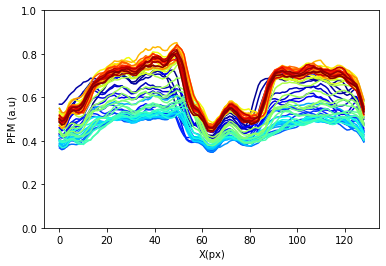

In [14]:
colors = plt.cm.jet(np.linspace(0,1,n_frames))
for i in range(n_frames):
    plt.plot(np.linspace(0,128,128),profiles_rec[i,:],color=colors[i])
plt.ylim([0,1])
plt.xlabel('X(px)')
plt.ylabel('PFM (a.u)')
plt.show()